In [13]:
%load_ext autoreload
%autoreload 2
from rankmotif import *
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
"""
seqs = ["ACTGATGGTA", "ATGGGGCATG", "AAAAAAAAAA", "CCCCCCCCTG", "ATGATGATGG"]
# Assume ATG is prefered in binding
bdPrefs = np.array([[0,0,1,1,0],
                    [1,0,1,1,0],
                    [0,0,0,0,0],
                    [0,0,1,0,0],
                    [1,1,1,1,0]]).astype(np.float32)
"""

'\nseqs = ["ACTGATGGTA", "ATGGGGCATG", "AAAAAAAAAA", "CCCCCCCCTG", "ATGATGATGG"]\n# Assume ATG is prefered in binding\nbdPrefs = np.array([[0,0,1,1,0],\n                    [1,0,1,1,0],\n                    [0,0,0,0,0],\n                    [0,0,1,0,0],\n                    [1,1,1,1,0]]).astype(np.float32)\n'

In [3]:
# Load pbm data
TFName = "TF_40"
seqs = pd.read_csv("./pbm/sequences.tsv", delimiter="\t")['seq'].tolist()
targets = pd.read_csv("./pbm/targets.tsv", delimiter="\t")
bscores = targets.as_matrix(columns=[TFName])
print("Number of sequences: {}".format(len(seqs)))
print("Number of binding scores: {}".format(len(bscores)))

Number of sequences: 80856
Number of binding scores: 80856


In [4]:
# Remove sequences with mismatched lengths
from scipy.stats import mode
lenArr = np.array([len(seqs[i]) for i in range(len(seqs))])
modeLen = mode(lenArr)[0][0]
count = 0
remove_indices = []
for i in range(len(seqs)):
    if len(seqs[i]) != modeLen:
        remove_indices.append(i)
        count += 1
nseqs = [seqs[i] for i in range(len(seqs)) if i not in remove_indices]
nbscores = np.delete(bscores, remove_indices)
seqs = nseqs
bscores = nbscores
print("Removed {0} entries, number of seqs is now {1}, number of binding scores is now {2}".format(count, len(seqs), len(bscores)))

Removed 3 entries, number of seqs is now 80853, number of binding scores is now 80853


In [5]:
# Train test split
n_split = round(0.7 * len(seqs))
seqs_train = seqs[:n_split]
bscores_train = bscores[:n_split]
seqs_test = seqs[n_split:]
bscores_test = bscores[n_split:]

In [6]:
r = RankMotifModel(K=3)
r.fit(seqs_train, bscores_train, ["A","T","G","C"], gdStepSize=0.01, batch_size=30, max_iter=int(1e5), verbose=int(1e4))

Epoch: 0/100000, negative log likelihood: 300.4814453125
Epoch: 10000/100000, negative log likelihood: 271.932373046875
Epoch: 20000/100000, negative log likelihood: 224.05491638183594
Epoch: 30000/100000, negative log likelihood: 267.8390197753906
Epoch: 40000/100000, negative log likelihood: 229.43484497070312
Epoch: 50000/100000, negative log likelihood: 254.4738311767578
Epoch: 60000/100000, negative log likelihood: 248.01998901367188
Epoch: 70000/100000, negative log likelihood: 250.14561462402344
Epoch: 80000/100000, negative log likelihood: 232.2215576171875
Epoch: 90000/100000, negative log likelihood: 235.82598876953125


In [7]:
test_batch_size = 20
num_test_batches = 50 # len(seqs_test) // test_batch_size
num_corr_pred = 0
num_total_pred = 0
for i in range(num_test_batches):
    batch_seq = seqs_test[i*test_batch_size:(i+1)*test_batch_size]
    batch_bscores = bscores_test[i*test_batch_size:(i+1)*test_batch_size]
    mat_pred = r.predict_proba(batch_seq)
    mat_true = bscores2PrefMat(batch_bscores)
    num_corr_pred += np.sum(1 - np.abs(mat_true - (mat_pred > 0.5)))
    num_total_pred += test_batch_size**2
    if i % 1 == 0:
        print("Test epoch: {0}/{1}".format(i, num_test_batches))
print("Accuracy: {}".format(num_corr_pred / num_total_pred))

/media/mu/OS/Users/CM/CS466/project/rankmotif/rankmotif.py:50: RuntimeWarning: invalid value encountered in greater
  pref[i, :] = (bscores[i] > bscores).astype(np.float32)


Test epoch: 0/50
Test epoch: 1/50
Test epoch: 2/50
Test epoch: 3/50
Test epoch: 4/50
Test epoch: 5/50
Test epoch: 6/50
Test epoch: 7/50
Test epoch: 8/50
Test epoch: 9/50
Test epoch: 10/50
Test epoch: 11/50
Test epoch: 12/50
Test epoch: 13/50
Test epoch: 14/50
Test epoch: 15/50
Test epoch: 16/50
Test epoch: 17/50
Test epoch: 18/50
Test epoch: 19/50
Test epoch: 20/50
Test epoch: 21/50
Test epoch: 22/50
Test epoch: 23/50
Test epoch: 24/50
Test epoch: 25/50
Test epoch: 26/50
Test epoch: 27/50
Test epoch: 28/50
Test epoch: 29/50
Test epoch: 30/50
Test epoch: 31/50
Test epoch: 32/50
Test epoch: 33/50
Test epoch: 34/50
Test epoch: 35/50
Test epoch: 36/50
Test epoch: 37/50
Test epoch: 38/50
Test epoch: 39/50
Test epoch: 40/50
Test epoch: 41/50
Test epoch: 42/50
Test epoch: 43/50
Test epoch: 44/50
Test epoch: 45/50
Test epoch: 46/50
Test epoch: 47/50
Test epoch: 48/50
Test epoch: 49/50
Accuracy: 0.6274


[[ 0.0556099   0.32524014  0.37299627  0.3735904   0.36005628  0.25891182
   0.20912594  0.3557854   0.2062826   0.3060696   0.28159738  0.2790596
   0.16520452  0.23798794  0.25597823  0.2013431   0.31196356  0.16161124
   0.23308046  0.21049787  0.25035462  0.11661319  0.22826304  0.2528504
   0.23152494  0.35391006  0.2195252  -0.07600296  0.04572055  0.11259553
  -0.03067494  0.14419837  0.18578616  0.14519845  0.04000156  0.2713434
   0.24053839  0.14851305  0.08784088  0.1326464 ]
 [ 0.56951445  0.15246405  0.04833584 -0.24868195 -0.0174087   0.05218118
  -0.1982458   0.06971007  0.07488321  0.05789963  0.12968157  0.1676091
  -0.10333522  0.17774765 -0.0778156   0.02768946  0.07507385 -0.36595473
  -0.4102607   0.09236813  0.14065361  0.09548528  0.17465843  0.06635317
   0.0418316   0.02559095  0.13619696 -0.08029851  0.03906024 -0.04087978
   0.02619106  0.13383938  0.05473239  0.20130005 -0.16173844  0.26879376
   0.25102043  0.48163304  0.12376206  0.2112928 ]
 [ 0.03415588 

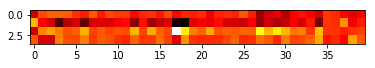

In [17]:
thetaMat = r.pwm_()
thetaMat = thetaMat / np.sum(thetaMat, axis=0)[None, :]
print(thetaMat)
plt.figure()
plt.imshow(thetaMat, cmap='hot', interpolation='nearest')
plt.savefig("learned_theta.png")
plt.show()

In [11]:
r.weight_()

2.733316